In [1]:
import xarray as xr
import rioxarray
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import time
import json
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func, dfi_func, ndti_func, satvi_func, ndii7_func
from src.hls_funcs.indices import bai_126_func, bai_136_func, bai_146_func, bai_236_func, bai_246_func, bai_346_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr

In [2]:
outPATH = 'data/bm_extract/TB_all_bm_veg_idxs.csv'

veg_dict = {
    'ndvi': ndvi_func,
    'dfi': dfi_func,
    'ndti': ndti_func,
    'satvi': satvi_func,
    'ndii7': ndii7_func,
    'bai_126': bai_126_func,
    'bai_136': bai_136_func,
    'bai_146': bai_146_func,
    'bai_236': bai_236_func,
    'bai_246': bai_246_func,
    'bai_346': bai_346_func
}

band_list = ['NIR1', 'SWIR1', 'SWIR2']

In [3]:
print('   setting up Local cluster...')
from dask.distributed import LocalCluster, Client
import dask
aws=False
fetch.setup_env(aws=aws)
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

   setting up Local cluster...


2022-07-17 08:21:55,610 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/tbng_veg/dask-worker-space/worker-3kd2894f', purging
2022-07-17 08:21:55,634 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/tbng_veg/dask-worker-space/worker-40g2rby2', purging
2022-07-17 08:21:55,668 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/tbng_veg/dask-worker-space/worker-6n7_7q7u', purging
2022-07-17 08:21:55,694 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/tbng_veg/dask-worker-space/worker-e8mzgh1g', purging
2022-07-17 08:21:55,721 - distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/tbng_veg/dask-worker-space/worker-gscup_db', purging
2022-07-17 08:21:55,746 - distributed.diskutils - INFO - Found stale lock file and directo

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35781,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:42565,Total threads: 2
Dashboard: http://127.0.0.1:41379/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:46367,


In [4]:
# load csv of ground data
df_aoi_txt = pd.read_csv('data/bm_extract/TB_all_bm.csv', parse_dates=[1])
# drop NEX transects in ungulate exclosures
df_aoi_txt = df_aoi_txt[~df_aoi_txt['ID'].str.contains('ungulate ex')]

# convert to GeoDataFrame using coordinates
gdf_aoi = gpd.GeoDataFrame(
    df_aoi_txt, geometry=gpd.points_from_xy(df_aoi_txt['gps_E'], df_aoi_txt['gps_N']))
# set the coordinate system
gdf_aoi = gdf_aoi.set_crs(epsg=32613)
# buffer the points to extract surrounding pixels later
gdf_aoi.geometry = gdf_aoi.buffer(150)
# convert the 'Date' column to date instead of timestamp
gdf_aoi['Date'] = gdf_aoi['Date'].dt.date

gdf_excl = gpd.read_file('data/shps/TBRI_study_areas_26jun2015.shp')
gdf_excl = gdf_excl.to_crs(epsg=32613)
gdf_excl = gdf_excl[(gdf_excl['Name'].notnull()) & (gdf_excl['Exclosure'] == 'Livestock Ex')]
gdf_excl['ID'] = gdf_excl.apply(lambda x: '-'.join([x['Name'].lower(), 
                                                    x['Disturbanc'].lower(), 
                                                    x['Exclosure'].lower()]), axis=1)
gdf_excl['ID'] = gdf_excl['ID'].transform(lambda x: re.sub('priarie', 'prairie', x))

In [5]:
if os.path.exists(outPATH):
    df_out = pd.read_csv(outPATH)
    gdf_aoi_sub = gdf_aoi[~gdf_aoi['ID'].isin(df_out['ID'])]
else:
    df_out = None
    gdf_aoi_sub = gdf_aoi

In [6]:
gdf_aoi_sub

,ID,Date,Project,gps_E,gps_N,bm_gm2,geometry
1352,E39.8,2015-06-30,BIRD,495848.000000,4.809987e+06,93.504477,"POLYGON ((495998.000 4809987.000, 495997.278 4..."
1353,E39.8,2016-07-20,BIRD,495848.000000,4.809987e+06,27.122870,"POLYGON ((495998.000 4809987.000, 495997.278 4..."
1354,E39.8,2017-07-05,BIRD,495848.000000,4.809987e+06,22.977760,"POLYGON ((495998.000 4809987.000, 495997.278 4..."
1355,E39.8,2018-07-01,BIRD,495848.000000,4.809987e+06,100.218019,"POLYGON ((495998.000 4809987.000, 495997.278 4..."
1356,E45.1,2015-08-17,BIRD,486172.000000,4.812067e+06,24.537230,"POLYGON ((486322.000 4812067.000, 486321.278 4..."
...,...,...,...,...,...,...,...
2988,wildcat-prairie dog-out,2019-07-03,NEX,517132.712854,4.836233e+06,406.680968,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
2989,wildcat-prairie dog-out,2019-08-05,NEX,517132.712854,4.836233e+06,310.526667,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
2990,wildcat-prairie dog-out,2020-07-13,NEX,517132.712854,4.836233e+06,64.748150,"POLYGON ((517282.713 4836232.742, 517281.991 4..."
2991,wildcat-prairie dog-out,2020-08-06,NEX,517132.712854,4.836233e+06,157.232000,"POLYGON ((517282.713 4836232.742, 517281.991 4..."


In [7]:
%%time
for idx, gdf_plot in tqdm(gdf_aoi_sub.iterrows(), total=gdf_aoi_sub.shape[0]):
    print(gdf_plot['ID'], ': ', gdf_plot['Date'])

    ### fetch the COG data
    # get the data range for the fetch
    if gdf_plot.Date.year < 2017:
        start_date = gdf_plot.Date - timedelta(days=60)
        end_date = gdf_plot.Date + timedelta(days=60)
    elif gdf_plot.Date.year == 2017:
        start_date = gdf_plot.Date - timedelta(days=50)
        end_date = gdf_plot.Date + timedelta(days=50)
    elif gdf_plot.Date.year > 2017:
        start_date = gdf_plot.Date - timedelta(days=45)
        end_date = gdf_plot.Date + timedelta(days=45)
    data_dict = {'date_range': [str(start_date), 
                                str(end_date)]}
    idx_load_try = 0
    max_load_try = 5
    while idx_load_try < max_load_try:
        try:
            # fetch the data
            hls_ds = fetch.get_hls(hls_data=data_dict,
                                   bbox=np.array(gdf_plot.geometry.bounds), 
                                   stack_chunks=(400, 400),
                                   proj_epsg=gdf_aoi.crs.to_epsg(),
                                   lim=1000,
                                   aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

            # mask the dataset using the native HLS mask
            hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
            hls_ds = hls_ds.where(hls_mask == 0, drop=True)

            # mask the dataset using the Bolton mask
            #hls_bolton_mask = bolton_mask(hls_ds)
            #hls_ds = hls_ds.where(hls_bolton_mask == 0, drop=True)

            # pick best image for any dates with duplicate images
            if len(np.unique(hls_ds.time.values)) < len(hls_ds.time.values):
                print('    reducing along id dimension to single observation for each date, keeping least-masked image')
                hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
                hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
                hls_ds = hls_ds.groupby('maskcov_pct').apply(
                    lambda x: x.sortby('maskcov_pct')).drop_duplicates(
                    'time', keep='first').sortby('time').drop_vars('maskcov_pct')

            hls_ds['time'] = pd.to_datetime(hls_ds['time'])
            hls_ds['time'] = hls_ds['time'].dt.date
            hls_ds = hls_ds.reset_coords(drop=True).drop_vars('FMASK')

            hls_ds['dist'] = np.sqrt((hls_ds['y'] - gdf_plot['gps_N'])**2 + ((hls_ds['x'] - gdf_plot['gps_E'])**2))

            hls_ds = hls_ds.set_coords('dist')#.sortby('dist')

            if gdf_plot['Project'] == 'NEX':
                print('masking livestock exclosure')
                gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot['ID'])]
                excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
                excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
                excl_mask = shp2mask(shp=excl_mask_shp, 
                                     transform=hls_ds.rio.transform(), 
                                     outshape=hls_ds['BLUE'].shape[1:], 
                                     xr_object=hls_ds['BLUE'])
                if gdf_plot['ID'].split('-')[-1] == 'livestock ex':
                    hls_ds = hls_ds.where(excl_mask == 1)
                elif gdf_plot['ID'].split('-')[-1] == 'out':
                    hls_ds = hls_ds.where(excl_mask == 0)
            
            max_dist = hls_ds.stack(z=['y', 'x']).where(
                hls_ds.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
                z=3)['dist']
            
            hls_plot = hls_ds.where(hls_ds['dist'] <= max_dist)

            hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()
            idx_load_try = max_load_try
            
        except RuntimeError as e:            
            print('Warning: error connecting to lpdaac. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)
            
        except rio.errors.RasterioIOError as e:
            print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)
        
        except json.decoder.JSONDecodeError:
            print('Warning: JSON decoding error (usually related to 502 Bad Gateway error).',
                  'Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
            client.restart()
            idx_load_try += 1
            time.sleep(10)

    print('   creating daily template for output...')
    # set the date range for analysis
    date_rng = pd.date_range(start=start_date, end=end_date)

    # create empty numpy array matching plot xarray dims
    dat_out_nans = np.zeros((len([x.date() for x in date_rng if x.date() not in hls_plot['time'].values]), 
                             hls_plot.dims['y'], 
                             hls_plot.dims['x'])) * np.nan

    # create dictionary to map variables to data and coords
    xr_empty_dict = {}
    for veg in veg_dict:
        xr_empty_dict[veg] = (['time', 'y', 'x'],
                                   dat_out_nans)
    for band in band_list:
        xr_empty_dict[band] = (['time', 'y', 'x'],
                                   dat_out_nans)

    # create the empty xarray Dataset for dates without imagery
    ds_empty = xr.Dataset(data_vars=xr_empty_dict,
                          coords={'time': [x.date() for x in date_rng if x.date() not in hls_plot['time'].values],
                                  'x': hls_plot.x,
                                  'y': hls_plot.y})

    xr_veg_list = []
    for veg in veg_dict:
        xr_veg_tmp = veg_dict[veg](hls_plot)
        xr_veg_tmp.name = veg
        xr_veg_list.append(xr_veg_tmp)
    for band in band_list:
        xr_veg_tmp = hls_plot[band]
        xr_veg_tmp.name = band
        xr_veg_list.append(xr_veg_tmp)

    ds_plot = xr.merge(xr_veg_list)

    ds_plot = xr.concat([ds_empty, ds_plot], dim='time').sortby('time').chunk({'time': -1, 'y': 1, 'x': 1})

    ds_plot['time'] = pd.to_datetime(ds_plot['time'])
    ds_plot['time'] = ds_plot['time'].dt.date

    ds_plot['ndvi'] = despike_ts_xr(ds_plot['ndvi'], dims=['time'], dat_thresh=0.075, days_thresh=60).persist()

    ds_plot = ds_plot.where(ds_plot['ndvi'].notnull())

    ds_plot_smooth = ds_plot.map(smooth_xr, dims=['time'])
    
    ds_plot_smooth = ds_plot_smooth.stack(z=['y', 'x'])
    ds_plot_smooth = ds_plot_smooth.where(ds_plot_smooth['dist'].notnull(), drop=True)

    df_plot_tmp = ds_plot_smooth.sel(
        time=[gdf_plot['Date']]).weighted(
        ds_plot_smooth.dist).mean('z').rename({'time':
                                                      'Date'}).to_dataframe().reset_index()
    df_plot_out = pd.merge(gdf_plot.to_frame().transpose(), df_plot_tmp, left_on='Date', right_on='Date')
    df_plot_out = df_plot_out.rename(columns={'NIR1': 'nir',
                                              'SWIR1': 'swir1',
                                              'SWIR2': 'swir2'})
    
    if df_out is None:
        print('creating initial dataframe')
        df_out = df_plot_out
    else:
        df_out = pd.concat([df_out, df_plot_out])
        df_out.to_csv('data/bm_extract/TB_all_bm_veg_idxs.csv', index=False)
    if idx%50 == 0:
        client.restart()

  0%|          | 0/1476 [00:00<?, ?it/s]

E39.8 :  2015-06-30
   creating daily template for output...
E39.8 :  2016-07-20
   creating daily template for output...
E39.8 :  2017-07-05
   creating daily template for output...
E39.8 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E45.1 :  2015-08-17
   creating daily template for output...
E45.1 :  2016-07-27
   creating daily template for output...
E45.1 :  2017-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E45.1 :  2018-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E45.2 :  2015-08-13
   creating daily template for output...
E45.2 :  2016-07-27
   creating daily template for output...
E45.2 :  2017-07-01
    reducing along id dimension to single observation for each date, keeping least

2022-07-17 08:44:08,701 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,750 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,759 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,785 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,813 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,828 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,828 - distributed.nanny - WARNING - Restarting worker
2022-07-17 08:44:08,882 - distributed.nanny - WARNING - Restarting worker


E46.3 :  2018-07-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E46.3 :  2019-07-30
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E46.4 :  2015-08-09
   creating daily template for output...
E46.4 :  2017-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E46.4 :  2018-07-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E46.4 :  2019-07-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E46.5 :  2015-08-09
   creating daily template for output...
E46.5 :  2016-06-29
   creating daily template for output...
E46.5 :  2017-07-01
    reducing

2022-07-17 09:07:06,851 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:06,853 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:06,863 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:06,880 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:06,888 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:06,898 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:07,047 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:07:07,084 - distributed.nanny - WARNING - Restarting worker


E47.4 :  2016-07-27
   creating daily template for output...
E47.4 :  2017-08-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E47.4 :  2018-06-18
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E47.4 :  2019-07-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E47.5 :  2015-08-13
   creating daily template for output...
E47.5 :  2016-07-27
   creating daily template for output...
E47.5 :  2017-08-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E47.5 :  2018-06-18
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E47.5 :  2019-07-24
    reducing

2022-07-17 09:26:32,540 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,550 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,551 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,581 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,668 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,716 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,723 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:26:32,725 - distributed.nanny - WARNING - Restarting worker


E5.1 :  2017-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.2 :  2015-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.2 :  2016-08-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.2 :  2017-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.3 :  2015-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.3 :  2016-08-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E5.3 :  2017-07-15
    reducing along id dimension to single obs

2022-07-17 09:45:21,656 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,659 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,670 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,690 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,813 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,823 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,847 - distributed.nanny - WARNING - Restarting worker
2022-07-17 09:45:21,867 - distributed.nanny - WARNING - Restarting worker


E52.2 :  2015-07-12
   creating daily template for output...
E52.2 :  2016-07-25
   creating daily template for output...
E52.2 :  2017-07-26
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E52.2 :  2017-08-07
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E52.2 :  2018-07-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E52.2 :  2019-07-16
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E52.2 :  2021-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E52.3 :  2015-07-12
   creating daily template for output...
E52.3 :  2016-07-25
   creating 

2022-07-17 10:04:31,429 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,439 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,465 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,491 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,517 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,541 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,616 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:04:31,779 - distributed.nanny - WARNING - Restarting worker


E57.2 :  2016-07-12
   creating daily template for output...
E57.2 :  2017-07-26
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E57.2 :  2017-07-31
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E57.3 :  2015-07-27
   creating daily template for output...
E57.3 :  2016-07-12
   creating daily template for output...
E57.3 :  2017-07-20
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E57.4 :  2015-07-27
   creating daily template for output...
E57.4 :  2017-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E57.5 :  2015-07-27
   creating daily template for output...
E57.5 :  2016-07-12
   creating daily template for output...
E57.5 

2022-07-17 10:24:39,246 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,265 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,266 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,305 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,331 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,351 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,386 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:24:39,402 - distributed.nanny - WARNING - Restarting worker


E60.5 :  2017-07-20
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E60.5 :  2017-08-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E60.5 :  2018-07-25
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E60.5 :  2019-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E60.5 :  2021-07-08
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E7.1 :  2015-08-06
   creating daily template for output...
E7.1 :  2017-07-17
   creating daily template for output...
E7.1 :  2019-06-18
    reducing along id dimension to single observation for each date, keeping

2022-07-17 10:44:20,496 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,561 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,562 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,584 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,591 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,598 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,610 - distributed.nanny - WARNING - Restarting worker
2022-07-17 10:44:20,612 - distributed.nanny - WARNING - Restarting worker


E8.2 :  2018-07-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E8.2 :  2019-07-16
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E8.2 :  2021-07-20
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E8.3 :  2015-08-17
   creating daily template for output...
E8.3 :  2016-08-09
   creating daily template for output...
E8.3 :  2017-07-07
   creating daily template for output...
E8.4 :  2015-08-17
   creating daily template for output...
E8.4 :  2016-08-09
   creating daily template for output...
E8.4 :  2017-07-17
   creating daily template for output...
E8.5 :  2015-08-17
   creating daily template for output...
E8.5 :  2016-08-09
   creating daily template for output...
E8.5 :  2017-07-17
   creating daily template for ou

2022-07-17 11:01:36,709 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,735 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,737 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,752 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,880 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,897 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,918 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:01:36,920 - distributed.nanny - WARNING - Restarting worker


E9.5 :  2017-07-04
   creating daily template for output...
E9.5 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
E9.5 :  2019-06-18
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
East_Weiss_Pt10_No :  2019-06-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
East_Weiss_Pt10_No :  2021-07-26
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
East_Weiss_Pt11_No :  2019-07-30
   creating daily template for output...
East_Weiss_Pt11_No :  2020-07-22
   creating daily template for output...
East_Weiss_Pt12_No :  2019-06-05
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating

2022-07-17 11:23:18,890 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:18,897 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:18,917 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:18,923 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:18,930 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:18,931 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:19,010 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:23:19,060 - distributed.nanny - WARNING - Restarting worker


East_Weiss_Pt8_No :  2020-07-22
   creating daily template for output...
East_Weiss_Pt9_No :  2019-06-05
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Hogsback_Pt10_No :  2021-06-16
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Hogsback_Pt10_No :  2021-07-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Hogsback_Pt11_No :  2021-07-06
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Hogsback_Pt14_No :  2021-06-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Hogsback_Pt14_No :  2021-07-19
    reducing along id dimension to single observation f

2022-07-17 11:47:16,111 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,132 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,185 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,215 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,223 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,235 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,301 - distributed.nanny - WARNING - Restarting worker
2022-07-17 11:47:16,308 - distributed.nanny - WARNING - Restarting worker


L10.2 :  2017-07-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.2 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.2 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.3 :  2015-08-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.3 :  2016-07-21
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.3 :  2017-07-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L10.3 :  2018-07-01
    reducing along id dimension to sin

2022-07-17 12:08:02,555 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,579 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,582 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,644 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,728 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,736 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,761 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:08:02,786 - distributed.nanny - WARNING - Restarting worker


L3.2 :  2016-08-08
   creating daily template for output...
L3.2 :  2017-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L3.3 :  2015-07-27
   creating daily template for output...
L3.3 :  2017-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L3.3 :  2017-07-31
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L3.4 :  2015-07-27
   creating daily template for output...
L3.4 :  2016-08-08
   creating daily template for output...
L3.4 :  2017-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L3.5 :  2015-07-27
   creating daily template for output...
L3.5 :  2016-08-08
   creating daily template for output...
L3.5 :  2017-07-

2022-07-17 12:31:41,541 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,592 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,659 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,660 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,666 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,688 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,739 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:31:41,746 - distributed.nanny - WARNING - Restarting worker


L4.7 :  2017-07-20
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2015-07-09
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2016-07-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2017-07-20
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2017-08-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2018-07-25
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L4.8 :  2021-07-08
    reducing along id dimension to single obs

2022-07-17 12:52:18,521 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,570 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,596 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,598 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,641 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,648 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,687 - distributed.nanny - WARNING - Restarting worker
2022-07-17 12:52:18,689 - distributed.nanny - WARNING - Restarting worker


L6.1 :  2016-07-05
   creating daily template for output...
L6.1 :  2017-07-09
   creating daily template for output...
L6.1 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.1 :  2019-06-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.2 :  2015-07-13
   creating daily template for output...
L6.2 :  2016-07-05
   creating daily template for output...
L6.2 :  2017-07-09
   creating daily template for output...
L6.2 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.2 :  2019-06-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.3 :  2015-07-13
   creating daily template for output...
L6.3 :  2016-07-

2022-07-17 12:58:38,005 - distributed.worker - ERROR - Exception during execution of task ('reshape-invert-1cd853ca18339fd2c2d6cd8a7035c979', 2).
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/worker.py", line 3851, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: "('xarray-dist-2fb3c9bde673f55b9d0bbfbd4a8f9558', 1, 0)"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/worker.py", line 3655, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/distributed/worker.py", line 3855, in _prepare

L6.4 :  2016-07-05
   creating daily template for output...
L6.4 :  2017-07-09
   creating daily template for output...
L6.4 :  2019-06-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.5 :  2015-07-13
   creating daily template for output...
L6.5 :  2016-07-05
   creating daily template for output...
L6.5 :  2017-07-09
   creating daily template for output...
L6.5 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.5 :  2019-06-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L6.6 :  2015-07-13
   creating daily template for output...
L6.6 :  2016-07-05
   creating daily template for output...
L6.6 :  2017-07-09
   creating daily template for output...
L6.6 :  2017-08-16
   creating daily template for ou

2022-07-17 13:10:34,450 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,486 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,487 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,499 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,539 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,548 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,555 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:10:34,588 - distributed.nanny - WARNING - Restarting worker


L7.3 :  2015-08-17
   creating daily template for output...
L7.3 :  2016-08-09
   creating daily template for output...
L7.3 :  2017-08-07
   creating daily template for output...
L7.4 :  2015-08-17
   creating daily template for output...
L7.4 :  2016-08-09
   creating daily template for output...
L7.4 :  2017-08-07
   creating daily template for output...
L7.5 :  2015-08-17
   creating daily template for output...
L7.5 :  2016-08-09
   creating daily template for output...
L7.5 :  2017-08-07
   creating daily template for output...
L7.6 :  2015-08-17
   creating daily template for output...
L7.6 :  2016-08-09
   creating daily template for output...
L7.6 :  2017-08-02
   creating daily template for output...
L7.6 :  2017-08-07
   creating daily template for output...
L7.6 :  2018-07-17
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L7.6 :  2019-07-16
    reducing along id dimension to single obs

2022-07-17 13:31:16,666 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,696 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,697 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,735 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,803 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,805 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,860 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:31:16,919 - distributed.nanny - WARNING - Restarting worker


L8.6 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.6 :  2019-06-19
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.7 :  2015-08-12
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.7 :  2016-07-29
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.7 :  2017-07-04
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.7 :  2018-07-01
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L8.7 :  2019-06-18
    reducing along id dimension to single obs

2022-07-17 13:53:33,840 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,862 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,879 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,904 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,923 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,935 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,937 - distributed.nanny - WARNING - Restarting worker
2022-07-17 13:53:33,997 - distributed.nanny - WARNING - Restarting worker


L9.8 :  2017-07-10
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
L9.8 :  2019-06-18
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt10_No :  2019-07-23
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt10_No :  2019-08-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt10_No :  2020-06-23
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt10_No :  2020-06-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Nort

2022-07-17 14:21:35,815 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,843 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,867 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,883 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,903 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,918 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,953 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:21:35,976 - distributed.nanny - WARNING - Restarting worker


North_Owens_Pt3_No :  2019-07-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt3_No :  2019-08-29
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt3_No :  2020-06-23
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt3_No :  2020-08-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt3_No :  2021-08-03
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt3_No :  2021-08-11
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily tem

2022-07-17 14:50:37,898 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:37,901 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:37,903 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:37,970 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:37,981 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:37,987 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:38,080 - distributed.nanny - WARNING - Restarting worker
2022-07-17 14:50:38,083 - distributed.nanny - WARNING - Restarting worker


North_Owens_Pt8_Yes :  2019-07-22
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt8_Yes :  2019-08-26
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt8_Yes :  2020-06-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt8_Yes :  2020-06-25
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt8_Yes :  2020-08-13
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
North_Owens_Pt9_No :  2019-07-24
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating dail

2022-07-17 15:19:30,060 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,080 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,169 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,185 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,196 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,249 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,250 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:19:30,252 - distributed.nanny - WARNING - Restarting worker


Top_Pt11_No :  2021-08-02
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt12_No :  2020-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt12_No :  2020-07-28
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt12_No :  2021-08-02
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt13_No :  2020-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt13_No :  2020-07-28
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Top_Pt13_No :  2021-08

2022-07-17 15:50:24,238 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,258 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,279 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,282 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,338 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,371 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,402 - distributed.nanny - WARNING - Restarting worker
2022-07-17 15:50:24,443 - distributed.nanny - WARNING - Restarting worker


Upper_Rattlesnake_Pt29_No :  2021-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Upper_Rattlesnake_Pt29_No :  2021-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Upper_Rattlesnake_Pt31_No :  2021-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Upper_Rattlesnake_Pt31_No :  2021-07-15
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Upper_Rattlesnake_Pt33_No :  2021-06-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
Upper_Rattlesnake_Pt34_No :  2021-06-29
    reducing along id dimension to single observation for each date, keepin

2022-07-17 16:12:25,779 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,852 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,889 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,921 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,924 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,937 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:12:25,993 - distributed.nanny - WARNING - Restarting worker


chey06-sc-out :  2015-07-14
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
cumm-c-in :  2015-08-20
   creating daily template for output...
drycr-c-in :  2015-07-20
   creating daily template for output...
drycr-c-out :  2015-07-20
   creating daily template for output...
drycr-l-in :  2015-07-23
   creating daily template for output...
drycr-sc-in :  2015-07-20
   creating daily template for output...
drycr-sc-out :  2015-07-20
   creating daily template for output...
dryfork-l-in :  2015-08-03
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
dryfork-l-out :  2015-08-03
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
erie-l-in :  2015-08-12
    reducing along id dimension to single observation for each date, keeping least-

2022-07-17 16:33:55,906 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:55,972 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:55,974 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:55,983 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:55,985 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:55,993 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:56,086 - distributed.nanny - WARNING - Restarting worker
2022-07-17 16:33:56,124 - distributed.nanny - WARNING - Restarting worker


lake creek-control-out :  2021-07-08
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
lake creek-fire-livestock ex :  2015-06-29
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
lake creek-fire-livestock ex :  2015-07-27
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
lake creek-fire-livestock ex :  2016-07-06
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
lake creek-fire-livestock ex :  2016-08-02
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   crea

2022-07-17 17:20:09,849 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:09,898 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:09,911 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:09,998 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:10,019 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:10,027 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:10,119 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:20:10,188 - distributed.nanny - WARNING - Worker process still alive after 1.5999988555908204 seconds, killing


steckley-control-livestock ex :  2019-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-control-livestock ex :  2019-07-29
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-control-livestock ex :  2020-07-07
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-control-livestock ex :  2020-08-10
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-control-livestock ex :  2021-06-28
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclos

2022-07-17 17:37:43,349 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,369 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,372 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,386 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,395 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,413 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,485 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:37:43,534 - distributed.nanny - WARNING - Restarting worker


steckley-fire-out :  2016-07-05
masking livestock exclosure
   creating daily template for output...
steckley-fire-out :  2016-08-03
masking livestock exclosure
   creating daily template for output...
steckley-fire-out :  2017-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-fire-out :  2017-07-17
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-fire-out :  2018-06-06
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-fire-out :  2018-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-f

2022-07-17 17:56:23,982 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,004 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,006 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,017 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,027 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,046 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,047 - distributed.nanny - WARNING - Restarting worker
2022-07-17 17:56:24,049 - distributed.nanny - WARNING - Restarting worker


steckley-prairie dog-out :  2020-07-06
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-prairie dog-out :  2020-07-07
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-prairie dog-out :  2020-08-10
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
steckley-prairie dog-out :  2021-06-30
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
tena-sl-in :  2015-08-03
    reducing along id dimension to single observation for each date, keeping least-masked image
   creating daily template for output...
tena-sl-out :  2015-08

2022-07-17 18:13:09,776 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,789 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,819 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,833 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,892 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,962 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:09,965 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:13:10,309 - distributed.nanny - WARNING - Restarting worker


west fork-control-out :  2019-07-09
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-control-out :  2019-08-07
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-control-out :  2020-07-13
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-control-out :  2020-08-05
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-control-out :  2021-07-13
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for outpu

2022-07-17 18:33:13,476 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,488 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,517 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,536 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,602 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,604 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,614 - distributed.nanny - WARNING - Restarting worker
2022-07-17 18:33:13,633 - distributed.nanny - WARNING - Restarting worker


west fork-prairie dog-livestock ex :  2015-07-08
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2015-07-27
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2016-06-28
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2016-08-01
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2017-06-27
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2017-07-19
    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure
   creating daily template for output...
west fork-prairie dog-livestock ex :  2018-06-04
    reducing along id dimension to single observati

2022-07-17 19:00:17,009 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,011 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,016 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,049 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,066 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,068 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,073 - distributed.nanny - WARNING - Restarting worker
2022-07-17 19:00:17,094 - distributed.nanny - WARNING - Restarting worker


wildcat-fire-livestock ex :  2015-07-13
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2015-08-01
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2016-06-28
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2016-08-01
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2017-07-05
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2017-07-18
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2018-06-05
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2018-06-27
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livestock ex :  2018-08-06
masking livestock exclosure
   creating daily template for output...
wildcat-fire-livest

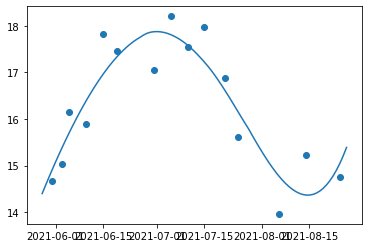

In [21]:
import matplotlib.pyplot as plt
plt.plot(ds_plot_smooth.time, ds_plot_smooth.dfi.mean('z').values)
plt.scatter(x=ds_plot.time, y=ds_plot.dfi.mean(['y', 'x']).values)

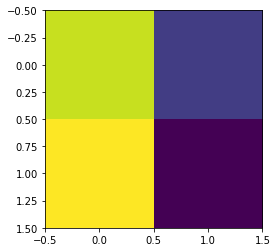

<AxesSubplot:>

In [25]:
from rasterio.plot import show
show(ds_plot_smooth.unstack().ndvi.isel(time=45).data)

In [173]:
# fetch the data
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=np.array(gdf_plot.geometry.bounds), 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000,
                       aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
hls_ds = hls_ds.where(hls_mask == 0, drop=True)

# mask the dataset using the Bolton mask
#hls_bolton_mask = bolton_mask(hls_ds)
#hls_ds = hls_ds.where(hls_bolton_mask == 0, drop=True)

# pick best image for any dates with duplicate images
if len(np.unique(hls_ds.time.values)) < len(hls_ds.time.values):
    print('    reducing along id dimension to single observation for each date, keeping least-masked image')
    hls_mask = mask_hls(hls_ds['FMASK'], mask_types=['all'])
    hls_ds['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds['FMASK'].isel(time=0).size * 100)#
    hls_ds = hls_ds.groupby('maskcov_pct').apply(
        lambda x: x.sortby('maskcov_pct')).drop_duplicates(
        'time', keep='first').sortby('time').drop_vars('maskcov_pct')

hls_ds['time'] = pd.to_datetime(hls_ds['time'])
hls_ds['time'] = hls_ds['time'].dt.date
hls_ds = hls_ds.reset_coords(drop=True).drop_vars('FMASK')

hls_ds['dist'] = np.sqrt((hls_ds['y'] - gdf_plot['gps_N'])**2 + ((hls_ds['x'] - gdf_plot['gps_E'])**2))

hls_ds = hls_ds.set_coords('dist')#.sortby('dist')

if gdf_plot['Project'] == 'NEX':
    print('masking livestock exclosure')
    gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot['ID'])]
    excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
    excl_mask = shp2mask(shp=excl_mask_shp, 
                         transform=hls_ds.transform, 
                         outshape=hls_ds['BLUE'].shape[1:], 
                         xr_object=hls_ds['BLUE'])
    if gdf_plot['ID'].split('-')[-1] == 'livestock ex':
        hls_ds = hls_ds.where(excl_mask == 1)
    elif gdf_plot['ID'].split('-')[-1] == 'out':
        hls_ds = hls_ds.where(excl_mask == 0)

max_dist = hls_ds.stack(z=['y', 'x']).where(
    hls_ds.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=3)['dist']

hls_plot = hls_ds.where(hls_ds['dist'] <= max_dist)

hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()

    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure


In [174]:
hls_plot

<xarray.Dataset>
Dimensions:  (time: 15, y: 2, x: 2)
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
  * x        (x) float64 5.171e+05 5.171e+05
  * y        (y) float64 4.836e+06 4.836e+06
    dist     (y, x) float64 23.84 10.29 32.14 23.88
    z        object (4836210.0, 517110.0)
Data variables:
    BLUE     (time, y, x) float64 707.0 621.0 714.0 637.0 ... 564.0 726.0 564.0
    GREEN    (time, y, x) float64 989.0 874.0 984.0 884.0 ... 802.0 998.0 788.0
    RED      (time, y, x) float64 1.175e+03 1.045e+03 ... 1.169e+03 892.0
    NIR1     (time, y, x) float64 2.061e+03 1.978e+03 ... 2.227e+03 1.992e+03
    SWIR1    (time, y, x) float64 3.421e+03 3.204e+03 ... 3.524e+03 3.069e+03
    SWIR2    (time, y, x) float64 2.592e+03 2.281e+03 ... 2.528e+03 2.061e+03
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(516960, 4836060, 517290, 4836...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 516960.00|\n| 0.00,-30.00, 4836390.00|\n| 0.0...
    resolution:  30

In [104]:
gdf_plot_test = gdf_aoi[gdf_aoi['ID'] == 'west fork-prairie dog-livestock ex'].iloc[-1]
gdf_excl = gpd.read_file('data/shps/TBRI_study_areas_26jun2015.shp')
gdf_excl = gdf_excl.to_crs(epsg=32613)
gdf_excl = gdf_excl[(gdf_excl['Name'].notnull()) & (gdf_excl['Exclosure'] == 'Livestock Ex')]
gdf_excl['ID'] = gdf_excl.apply(lambda x: '-'.join([x['Name'].lower(), 
                                                    x['Disturbanc'].lower(), 
                                                    x['Exclosure'].lower()]), axis=1)
gdf_excl['ID'] = gdf_excl['ID'].transform(lambda x: re.sub('priarie', 'prairie', x))

In [162]:
start_date = gdf_plot_test.Date - timedelta(days=45)
data_dict_test = {'date_range': [str(start_date), 
                                 str(start_date + timedelta(days=5))]}
# fetch the data
hls_ds_test = fetch.get_hls(hls_data=data_dict,
                       bbox=np.array(gdf_plot_test.geometry.buffer(200).bounds), 
                       stack_chunks=(400, 400),
                       proj_epsg=gdf_aoi.crs.to_epsg(),
                       lim=1000,
                       aws=aws).drop_vars(['SZA', 'SAA', 'VZA', 'VAA']).chunk({'time': -1}).persist()

# mask the dataset using the native HLS mask
hls_mask = mask_hls(hls_ds_test['FMASK'], mask_types=['all'])
hls_ds_test = hls_ds_test.where(hls_mask == 0, drop=True)

# mask the dataset using the Bolton mask
#hls_bolton_mask = bolton_mask(hls_ds_test)
#hls_ds_test = hls_ds_test.where(hls_bolton_mask == 0, drop=True)

# pick best image for any dates with duplicate images
if len(np.unique(hls_ds_test.time.values)) < len(hls_ds_test.time.values):
    print('    reducing along id dimension to single observation for each date, keeping least-masked image')
    hls_mask = mask_hls(hls_ds_test['FMASK'], mask_types=['all'])
    hls_ds_test['maskcov_pct'] = ((hls_mask != 0).sum(['y', 'x']) / hls_ds_test['FMASK'].isel(time=0).size * 100)#
    hls_ds_test = hls_ds_test.groupby('maskcov_pct').apply(
        lambda x: x.sortby('maskcov_pct')).drop_duplicates(
        'time', keep='first').sortby('time').drop_vars('maskcov_pct')

hls_ds_test['time'] = pd.to_datetime(hls_ds_test['time'])
hls_ds_test['time'] = hls_ds_test['time'].dt.date
hls_ds_test = hls_ds_test.reset_coords(drop=True).drop_vars('FMASK')

hls_ds_test['dist'] = np.sqrt((hls_ds_test['y'] - gdf_plot_test['gps_N'])**2 + ((hls_ds_test['x'] - gdf_plot_test['gps_E'])**2))

hls_ds_test = hls_ds_test.set_coords('dist')#.sortby('dist')

if gdf_plot_test['Project'] == 'NEX':
    print('masking livestock exclosure')
    gdf_excl_plot = gdf_excl[gdf_excl['ID'] == re.sub('out', 'livestock ex', gdf_plot_test['ID'])]
    excl_info = gdf_excl_plot[['ID', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    excl_mask_shp = [(row.geometry, 1) for _, row in excl_info.iterrows()]
    excl_mask = shp2mask(shp=excl_mask_shp, 
                         transform=hls_ds_test.rio.transform(), 
                         outshape=hls_ds_test['BLUE'].shape[1:], 
                         xr_object=hls_ds_test['BLUE'],
                         all_touched=False)
    if gdf_plot_test['ID'].split('-')[-1] == 'livestock ex':
        hls_ds_test = hls_ds_test.where(excl_mask == 1)
    elif gdf_plot_test['ID'].split('-')[-1] == 'out':
        hls_ds_test = hls_ds_test.where(excl_mask == 0)

    reducing along id dimension to single observation for each date, keeping least-masked image
masking livestock exclosure


In [99]:
from rasterio.features import Affine
orig_transform = hls_ds_test.rio.transform()
shift_transform = Affine(orig_transform[0], orig_transform[1], orig_transform[2]+(0.5*orig_transform[0]),
                         orig_transform[3], orig_transform[4], orig_transform[5]-(0.5*orig_transform[0]))

In [154]:
gdf_plot_test

ID                         west fork-prairie dog-livestock ex
Date                                               2021-07-13
Project                                                   NEX
gps_E                                           487230.122072
gps_N                                          4822876.010324
bm_gm2                                              89.344629
geometry    POLYGON ((487380.1220723571 4822876.010324053,...
Name: 2831, dtype: object

In [177]:
max_dist = hls_ds_test.stack(z=['y', 'x']).where(
    hls_ds_test.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=3)['dist']

In [180]:
hls_ds_test['NIR1'].where((hls_ds_test['dist'] <= max_dist) & 
                          (hls_ds_test['NIR1'].notnull()), drop=True)

<xarray.DataArray 'NIR1' (time: 16, y: 2, x: 2)>
dask.array<where, shape=(16, 2, 2), dtype=float64, chunksize=(16, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
  * x        (x) float64 4.872e+05 4.872e+05
  * y        (y) float64 4.823e+06 4.823e+06
    dist     (y, x) float64 34.11 16.01 54.99 46.01
    z        object (4822830.0, 487200.0)

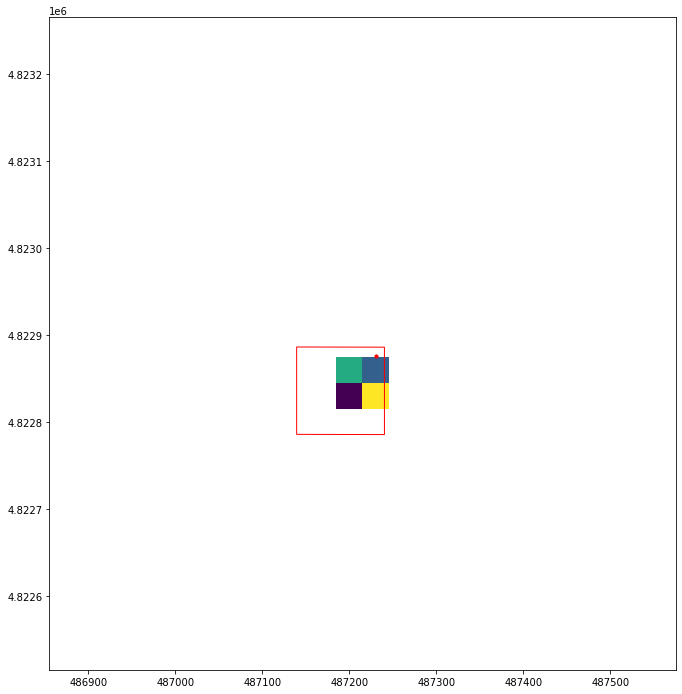

In [165]:
fig, ax = plt.subplots(figsize=(12, 12))
show(hls_ds_test['NIR1'].where(hls_ds_test['dist'] <= max_dist).isel(time=1).data, transform=hls_ds_test.rio.transform(), ax=ax)
xs, ys = gdf_excl_plot.iloc[0].geometry.exterior.xy
ax.fill(xs, ys, alpha=1, fc='none', ec='r')
ax.scatter(gdf_plot_test['gps_E'], gdf_plot_test['gps_N'], c='r', s=10)

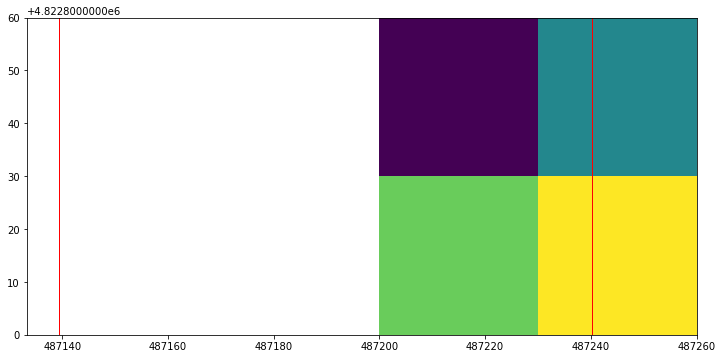

In [166]:
hls_plot = hls_ds_test.stack(z=['y', 'x']).where(
    hls_ds_test.stack(z=['y', 'x']).notnull(), drop=True).sortby('dist').isel(
    z=slice(0,4), drop=True).unstack()

hls_plot = hls_plot.where(hls_plot['BLUE'].notnull(), drop=True).compute()
fig, ax = plt.subplots(figsize=(12, 12))
#show(hls_ds_test['dist'].data, transform=hls_ds_test.transform, ax=ax)
show(hls_plot['dist'].data, transform=Affine(30.0, 0.0, hls_plot.x.min(), 0.0, -30.0, hls_plot.y.max()), ax=ax)
ax.fill(xs, ys, alpha=1, fc='none', ec='r')
ax.scatter(gdf_plot_test['gps_E'], gdf_plot_test['gps_N'], c='r', s=10)

In [112]:
hls_plot

<xarray.Dataset>
Dimensions:  (time: 16, y: 3, x: 2)
Coordinates:
  * time     (time) object 2021-05-31 2021-06-03 ... 2021-08-14 2021-08-24
    dist     (y, x) float64 33.21 61.73 34.11 nan 54.99 nan
  * y        (y) float64 4.823e+06 4.823e+06 4.823e+06
  * x        (x) float64 4.872e+05 4.872e+05
Data variables:
    BLUE     (time, y, x) float64 751.0 740.0 749.0 nan ... 570.0 nan 576.0 nan
    GREEN    (time, y, x) float64 986.0 976.0 989.0 nan ... 759.0 nan 768.0 nan
    RED      (time, y, x) float64 1.124e+03 1.11e+03 1.145e+03 ... nan 871.0 nan
    NIR1     (time, y, x) float64 1.986e+03 1.977e+03 ... 1.797e+03 nan
    SWIR1    (time, y, x) float64 3.182e+03 3.162e+03 3.18e+03 ... 2.818e+03 nan
    SWIR2    (time, y, x) float64 2.334e+03 2.298e+03 ... 1.959e+03 nan
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(486870, 4822500, 487590, 4823...
    crs:         epsg:32613
    transform:   | 30.00, 0.00, 486870.00|\n| 0.00,-30.00, 4823250.00|\n| 0.0...
    resolution:  30